In [1]:
#| default_exp losses.pytorch

In [2]:
#| hide
%load_ext autoreload
%autoreload 2

# PyTorch Losses

> NeuralForecast contains a collection PyTorch Loss classes aimed to be used during the models' optimization. The most important train signal is the forecast error, which is the difference between the observed value $y_{\tau}$ and the prediction $\hat{y}_{\tau}$, at time $y_{\tau}$:$$e_{\tau} = y_{\tau}-\hat{y}_{\tau} \qquad \qquad \tau \in \{t+1,\dots,t+H \}$$ The train loss summarizes the forecast errors in different train optimization objectives.<br><br>All the losses are `torch.nn.modules` which helps to automatically moved them across CPU/GPU/TPU devices with Pytorch Lightning. 

In [3]:
#| export
from typing import Optional, Union, Tuple, Callable, Type, Dict

import math
import numpy as np
import torch

import torch.nn.functional as F
from torch.distributions import Normal, StudentT, Poisson
from torch.distributions import (
    AffineTransform,
    Distribution,
    TransformedDistribution,
)
# from torch.distributions import (
#     Beta,
#     Distribution,
#     Gamma,
#     NegativeBinomial,
#     Normal,
#     Poisson,
#     StudentT,
# )

# from neuralforecast.common.modules import MLP

In [4]:
#| hide
import matplotlib.pyplot as plt
from fastcore.test import test_eq
from nbdev.showdoc import show_doc
from neuralforecast.utils import generate_series

In [5]:
#| exporti
def _divide_no_nan(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    """
    Auxiliary funtion to handle divide by 0
    """
    div = a / b
    div[div != div] = 0.0
    div[div == float('inf')] = 0.0
    return div

In [6]:
#| exporti
ACTIVATIONS = ['ReLU','Softplus','Tanh','SELU','LeakyReLU','PReLU','Sigmoid']

class MLP(torch.nn.Module):
    """Multi-Layer Perceptron Class

    **Parameters:**<br>
    `in_features`: int, dimension of input.<br>
    `out_features`: int, dimension of output.<br>
    `activation`: str, activation function to use.<br>
    `hidden_size`: int, dimension of hidden layers.<br>
    `num_layers`: int, number of hidden layers.<br>
    `dropout`: float, dropout rate.<br>
    """
    def __init__(self, in_features, out_features, activation, hidden_size, num_layers, dropout):
        super().__init__()
        assert activation in ACTIVATIONS, f'{activation} is not in {ACTIVATIONS}'
        
        self.activation = getattr(torch.nn, activation)()

        # MultiLayer Perceptron
        # Input layer
        layers = [torch.nn.Linear(in_features=in_features, out_features=hidden_size),
                  self.activation,
                  torch.nn.Dropout(dropout)]
        # Hidden layers
        for i in range(num_layers - 2):
            layers += [torch.nn.Linear(in_features=hidden_size, out_features=hidden_size),
                       self.activation,
                       torch.nn.Dropout(dropout)]
        # Output layer
        layers += [torch.nn.Linear(in_features=hidden_size, out_features=out_features)]

        # Store in layers as ModuleList
        self.layers = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


class Adapter(torch.nn.Module):
    """
    PyTorch module that automatically defines a dense layer that 
    projects the last hidden layer to the losses' arguments.

    **Parameters**<br>
    `in_features`: int, dimension of input.<br>
    `args_dim`: dictionary, dimension of each loss argument.<br>
    `domain_map`: function, a function that receives network's outputs and 
        adapts them to match the losses' domain. Example distributions with
        parameters constraints.<br>
    """
    def __init__(self,
                 in_features: int,
                 args_dim: Dict[str, int],
                 domain_map,
                 **kwargs,) -> None:
        super().__init__(**kwargs)
        self.args_dim = args_dim
        #self.proj = torch.nn.ModuleList(
        #    [torch.nn.Linear(in_features, dim) for dim in args_dim.values()]
        #)
        self.proj = torch.nn.ModuleList(
            [MLP(in_features=in_features, out_features=dim,
                 activation='ReLU', hidden_size=10, num_layers=2, dropout=0.)
                 for dim in args_dim.values()]
        )
        self.domain_map = domain_map

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor]:
        x = [proj(x) for proj in self.proj]
        return self.domain_map(*x)


class LambdaLayer(torch.nn.Module):
    def __init__(self, function):
        super().__init__()
        self._func = function

    def forward(self, x, *args):
        return self._func(x, *args)

# <span style="color:DarkBlue">1. Scale-dependent Errors </span>

These metrics are on the same scale as the data.

## Mean Absolute Error (MAE)

In [7]:
#| export
class MAE(torch.nn.Module):
    """Mean Absolute Error

    Calculates Mean Absolute Error between
    `y` and `y_hat`. MAE measures the relative prediction
    accuracy of a forecasting method by calculating the
    deviation of the prediction and the true
    value at a given time and averages these devations
    over the length of the series.

    $$ \mathrm{MAE}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}) = \\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} |y_{\\tau} - \hat{y}_{\\tau}| $$
    """    
    def __init__(self):
        super(MAE, self).__init__()
        self.outputsize_multiplier = 1
        self.output_names = ['']
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        return [y_hat.squeeze(-1)]

    def get_adapter(self, in_features: int) -> torch.nn.Module:
        return Adapter(in_features=in_features, 
                       args_dim={'y_hat': 1},
                       domain_map=self.domain_map)

    def __call__(self, y: torch.Tensor, y_hat: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None):
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `mae`: tensor (single value).
        """
        if mask is None:
            mask = torch.ones_like(y)

        mae = torch.abs(y - y_hat) * mask
        mae = torch.mean(mae)
        return mae

In [8]:
show_doc(MAE, name='MAE.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L83){target="_blank" style="float:right; font-size:smaller"}

### MAE.__init__

>      MAE.__init__ ()

Mean Absolute Error

Calculates Mean Absolute Error between
`y` and `y_hat`. MAE measures the relative prediction
accuracy of a forecasting method by calculating the
deviation of the prediction and the true
value at a given time and averages these devations
over the length of the series.

$$ \mathrm{MAE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} |y_{\tau} - \hat{y}_{\tau}| $$

In [9]:
show_doc(MAE.__call__, name='MAE.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L104){target="_blank" style="float:right; font-size:smaller"}

### MAE.__call__

>      MAE.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                    mask:Optional[torch.Tensor]=None)

**Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`mae`: tensor (single value).

![](imgs_losses/mae_loss.png)

## Mean Squared Error (MSE)

In [10]:
#| export
class MSE(torch.nn.Module):
    """  Mean Squared Error

    Calculates Mean Squared Error between
    `y` and `y_hat`. MSE measures the relative prediction
    accuracy of a forecasting method by calculating the 
    squared deviation of the prediction and the true
    value at a given time, and averages these devations
    over the length of the series.
    
    $$ \mathrm{MSE}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}) = \\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} (y_{\\tau} - \hat{y}_{\\tau})^{2} $$
    """    
    def __init__(self):
        super(MSE, self).__init__()
        self.outputsize_multiplier = 1
        self.output_names = ['']
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        return [y_hat.squeeze(-1)]        

    def get_adapter(self, in_features: int) -> torch.nn.Module:
        return Adapter(in_features=in_features,
                       args_dim={'y_hat': 1},
                       domain_map=self.domain_map)

    def __call__(self, y: torch.Tensor, y_hat: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None):
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `mse`: tensor (single value).
        """
        if mask is None:
            mask = torch.ones_like(y_hat)

        mse = (y - y_hat)**2
        mse = mask * mse
        mse = torch.mean(mse)
        return mse

In [11]:
show_doc(MSE, name='MSE.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L123){target="_blank" style="float:right; font-size:smaller"}

### MSE.__init__

>      MSE.__init__ ()

Mean Squared Error

Calculates Mean Squared Error between
`y` and `y_hat`. MSE measures the relative prediction
accuracy of a forecasting method by calculating the 
squared deviation of the prediction and the true
value at a given time, and averages these devations
over the length of the series.

$$ \mathrm{MSE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} (y_{\tau} - \hat{y}_{\tau})^{2} $$

In [12]:
show_doc(MSE.__call__, name='MSE.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L144){target="_blank" style="float:right; font-size:smaller"}

### MSE.__call__

>      MSE.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                    mask:Optional[torch.Tensor]=None)

**Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`mse`: tensor (single value).

![](imgs_losses/mse_loss.png)

## Root Mean Squared Error (RMSE)

In [13]:
#| export
class RMSE(torch.nn.Module):
    """ Root Mean Squared Error

    Calculates Root Mean Squared Error between
    `y` and `y_hat`. RMSE measures the relative prediction
    accuracy of a forecasting method by calculating the squared deviation
    of the prediction and the observed value at a given time and
    averages these devations over the length of the series.
    Finally the RMSE will be in the same scale
    as the original time series so its comparison with other
    series is possible only if they share a common scale. 
    RMSE has a direct connection to the L2 norm.
    
    $$ \mathrm{RMSE}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}) = \\sqrt{\\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} (y_{\\tau} - \hat{y}_{\\tau})^{2}} $$
    """
    def __init__(self):
        super(RMSE, self).__init__()
        self.outputsize_multiplier = 1
        self.output_names = ['']
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        return [y_hat.squeeze(-1)]        

    def get_adapter(self, in_features: int) -> torch.nn.Module:
        return Adapter(in_features=in_features,
                       args_dim={'y_hat': 1},
                       domain_map=self.domain_map)

    def __call__(self, y: torch.Tensor, y_hat: torch.Tensor, 
                 mask: Union[torch.Tensor, None] = None):
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `rmse`: tensor (single value).
        """
        if mask is None: 
            mask = torch.ones_like(y_hat)

        mse = (y - y_hat)**2
        mse = mask * mse
        mse = torch.mean(mse)
        mse = torch.sqrt(mse)
        return mse

In [14]:
show_doc(RMSE, name='RMSE.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L164){target="_blank" style="float:right; font-size:smaller"}

### RMSE.__init__

>      RMSE.__init__ ()

Root Mean Squared Error

Calculates Root Mean Squared Error between
`y` and `y_hat`. RMSE measures the relative prediction
accuracy of a forecasting method by calculating the squared deviation
of the prediction and the observed value at a given time and
averages these devations over the length of the series.
Finally the RMSE will be in the same scale
as the original time series so its comparison with other
series is possible only if they share a common scale. 
RMSE has a direct connection to the L2 norm.

$$ \mathrm{RMSE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \sqrt{\frac{1}{H} \sum^{t+H}_{\tau=t+1} (y_{\tau} - \hat{y}_{\tau})^{2}} $$

In [15]:
show_doc(RMSE.__call__, name='RMSE.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L188){target="_blank" style="float:right; font-size:smaller"}

### RMSE.__call__

>      RMSE.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                     mask:Optional[torch.Tensor]=None)

**Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`rmse`: tensor (single value).

![](imgs_losses/rmse_loss.png)

# <span style="color:DarkBlue"> 2. Percentage errors </span>

These metrics are unit-free, suitable for comparisons across series.

## Mean Absolute Percentage Error (MAPE)

In [16]:
#| export
class MAPE(torch.nn.Module):
    """ Mean Absolute Percentage Error

    Calculates Mean Absolute Percentage Error  between
    `y` and `y_hat`. MAPE measures the relative prediction
    accuracy of a forecasting method by calculating the percentual deviation
    of the prediction and the observed value at a given time and
    averages these devations over the length of the series.
    The closer to zero an observed value is, the higher penalty MAPE loss
    assigns to the corresponding error.
    
    $$ \mathrm{MAPE}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}) = \\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} \\frac{|y_{\\tau}-\hat{y}_{\\tau}|}{|y_{\\tau}|} $$
    """    
    def __init__(self):
        super(MAPE, self).__init__()
        self.outputsize_multiplier = 1
        self.output_names = ['']
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        return [y_hat.squeeze(-1)]        

    def get_adapter(self, in_features: int) -> torch.nn.Module:
        return Adapter(in_features=in_features,
                       args_dim={'y_hat': 1},
                       domain_map=self.domain_map)

    def __call__(self, y: torch.Tensor, y_hat: torch.Tensor, 
                 mask: Union[torch.Tensor, None] = None):
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `mape`: tensor (single value).
        """
        if mask is None: 
            mask = torch.ones_like(y_hat)

        mask = _divide_no_nan(mask, torch.abs(y))
        mape = torch.abs(y - y_hat) * mask
        mape = torch.mean(mape)
        return mape

In [17]:
show_doc(MAPE, name='MAPE.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L209){target="_blank" style="float:right; font-size:smaller"}

### MAPE.__init__

>      MAPE.__init__ ()

Mean Absolute Percentage Error

Calculates Mean Absolute Percentage Error  between
`y` and `y_hat`. MAPE measures the relative prediction
accuracy of a forecasting method by calculating the percentual deviation
of the prediction and the observed value at a given time and
averages these devations over the length of the series.
The closer to zero an observed value is, the higher penalty MAPE loss
assigns to the corresponding error.

$$ \mathrm{MAPE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} \frac{|y_{\tau}-\hat{y}_{\tau}|}{|y_{\tau}|} $$

In [18]:
show_doc(MAPE.__call__, name='MAPE.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L231){target="_blank" style="float:right; font-size:smaller"}

### MAPE.__call__

>      MAPE.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                     mask:Optional[torch.Tensor]=None)

**Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`mape`: tensor (single value).

![](imgs_losses/mape_loss.png)

## Symmetric MAPE (sMAPE)

In [19]:
#| export
class SMAPE(torch.nn.Module):
    """ Symmetric Mean Absolute Percentage Error

    Calculates Symmetric Mean Absolute Percentage Error between
    `y` and `y_hat`. SMAPE measures the relative prediction
    accuracy of a forecasting method by calculating the relative deviation
    of the prediction and the observed value scaled by the sum of the
    absolute values for the prediction and observed value at a
    given time, then averages these devations over the length
    of the series. This allows the SMAPE to have bounds between
    0% and 200% which is desireble compared to normal MAPE that
    may be undetermined when the target is zero.

    $$ \mathrm{sMAPE}_{2}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}) = \\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} \\frac{|y_{\\tau}-\hat{y}_{\\tau}|}{|y_{\\tau}|+|\hat{y}_{\\tau}|} $$

    **References:**<br>
    [Makridakis S., "Accuracy measures: theoretical and practical concerns".](https://www.sciencedirect.com/science/article/pii/0169207093900793)
    """
    def __init__(self):
        super(SMAPE, self).__init__()
        self.outputsize_multiplier = 1
        self.output_names = ['']
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        return [y_hat.squeeze(-1)]        

    def get_adapter(self, in_features: int) -> torch.nn.Module:
        return Adapter(in_features=in_features,
                       args_dim={'y_hat': 1},
                       domain_map=self.domain_map)

    def __call__(self, y: torch.Tensor, y_hat: torch.Tensor, 
                 mask: Union[torch.Tensor, None] = None):
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `smape`: tensor (single value).
        """
        if mask is None: 
            mask = torch.ones_like(y_hat)

        delta_y = torch.abs((y - y_hat))
        scale = torch.abs(y) + torch.abs(y_hat)
        smape = _divide_no_nan(delta_y, scale)
        smape = smape * mask
        smape = 2 * torch.mean(smape)
        return smape

In [20]:
show_doc(SMAPE, name='SMAPE.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L251){target="_blank" style="float:right; font-size:smaller"}

### SMAPE.__init__

>      SMAPE.__init__ ()

Symmetric Mean Absolute Percentage Error

Calculates Symmetric Mean Absolute Percentage Error between
`y` and `y_hat`. SMAPE measures the relative prediction
accuracy of a forecasting method by calculating the relative deviation
of the prediction and the observed value scaled by the sum of the
absolute values for the prediction and observed value at a
given time, then averages these devations over the length
of the series. This allows the SMAPE to have bounds between
0% and 200% which is desireble compared to normal MAPE that
may be undetermined when the target is zero.

$$ \mathrm{sMAPE}_{2}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} \frac{|y_{\tau}-\hat{y}_{\tau}|}{|y_{\tau}|+|\hat{y}_{\tau}|} $$

**References:**<br>
[Makridakis S., "Accuracy measures: theoretical and practical concerns".](https://www.sciencedirect.com/science/article/pii/0169207093900793)

In [21]:
show_doc(SMAPE.__call__, name='SMAPE.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L278){target="_blank" style="float:right; font-size:smaller"}

### SMAPE.__call__

>      SMAPE.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                      mask:Optional[torch.Tensor]=None)

**Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`smape`: tensor (single value).

# <span style="color:DarkBlue"> 3. Scale-independent Errors </span>

These metrics measure the relative improvements versus baselines.

## Mean Absolute Scaled Error (MASE)

In [22]:
#| export
class MASE(torch.nn.Module):
    """ Mean Absolute Scaled Error 
    Calculates the Mean Absolute Scaled Error between
    `y` and `y_hat`. MASE measures the relative prediction
    accuracy of a forecasting method by comparinng the mean absolute errors
    of the prediction and the observed value against the mean
    absolute errors of the seasonal naive model.
    The MASE partially composed the Overall Weighted Average (OWA), 
    used in the M4 Competition.
    
    $$ \mathrm{MASE}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}_{\\tau}, \\mathbf{\hat{y}}^{season}_{\\tau}) = \\frac{1}{H} \sum^{t+H}_{\\tau=t+1} \\frac{|y_{\\tau}-\hat{y}_{\\tau}|}{\mathrm{MAE}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}^{season}_{\\tau})} $$

    **Parameters:**<br>
    `seasonality`: int. Main frequency of the time series; Hourly 24,  Daily 7, Weekly 52, Monthly 12, Quarterly 4, Yearly 1.
    
    **References:**<br>
    [Rob J. Hyndman, & Koehler, A. B. "Another look at measures of forecast accuracy".](https://www.sciencedirect.com/science/article/pii/S0169207006000239)<br>
    [Spyros Makridakis, Evangelos Spiliotis, Vassilios Assimakopoulos, "The M4 Competition: 100,000 time series and 61 forecasting methods".](https://www.sciencedirect.com/science/article/pii/S0169207019301128)
    """
    def __init__(self, seasonality: int):
        super(MASE, self).__init__()
        self.outputsize_multiplier = 1
        self.seasonality = seasonality
        self.output_names = ['']
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        return [y_hat.squeeze(-1)]        

    def get_adapter(self, in_features: int) -> torch.nn.Module:
        return Adapter(in_features=in_features,
                       args_dim={'y_hat': 1},
                       domain_map=self.domain_map)

    def __call__(self, y: torch.Tensor, y_hat: torch.Tensor,  y_insample: torch.Tensor, 
                 mask: Union[torch.Tensor, None] = None):
        """
        **Parameters:**<br>
        `y`: tensor (batch_size, output_size), Actual values.<br>
        `y_hat`: tensor (batch_size, output_size)), Predicted values.<br>
        `y_insample`: tensor (batch_size, input_size), Actual insample Seasonal Naive predictions.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `mase`: tensor (single value).
        """
        if mask is None: 
            mask = torch.ones_like(y_hat)

        delta_y = torch.abs(y - y_hat)
        scale = torch.mean(torch.abs(y_insample[:, self.seasonality:] - \
                                     y_insample[:, :-self.seasonality]), axis=1)
        mase = _divide_no_nan(delta_y, scale[:, None])
        mase = mase * mask
        mase = torch.mean(mase)
        return mase

In [23]:
show_doc(MASE, name='MASE.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L300){target="_blank" style="float:right; font-size:smaller"}

### MASE.__init__

>      MASE.__init__ (seasonality:int)

Mean Absolute Scaled Error 
Calculates the Mean Absolute Scaled Error between
`y` and `y_hat`. MASE measures the relative prediction
accuracy of a forecasting method by comparinng the mean absolute errors
of the prediction and the observed value against the mean
absolute errors of the seasonal naive model.
The MASE partially composed the Overall Weighted Average (OWA), 
used in the M4 Competition.

$$ \mathrm{MASE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}_{\tau}, \mathbf{\hat{y}}^{season}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} \frac{|y_{\tau}-\hat{y}_{\tau}|}{\mathrm{MAE}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}^{season}_{\tau})} $$

**Parameters:**<br>
`seasonality`: int. Main frequency of the time series; Hourly 24,  Daily 7, Weekly 52, Monthly 12, Quarterly 4, Yearly 1.

**References:**<br>
[Rob J. Hyndman, & Koehler, A. B. "Another look at measures of forecast accuracy".](https://www.sciencedirect.com/science/article/pii/S0169207006000239)<br>
[Spyros Makridakis, Evangelos Spiliotis, Vassilios Assimakopoulos, "The M4 Competition: 100,000 time series and 61 forecasting methods".](https://www.sciencedirect.com/science/article/pii/S0169207019301128)

In [24]:
show_doc(MASE.__call__, name='MASE.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L329){target="_blank" style="float:right; font-size:smaller"}

### MASE.__call__

>      MASE.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                     y_insample:torch.Tensor, mask:Optional[torch.Tensor]=None)

**Parameters:**<br>
`y`: tensor (batch_size, output_size), Actual values.<br>
`y_hat`: tensor (batch_size, output_size)), Predicted values.<br>
`y_insample`: tensor (batch_size, input_size), Actual insample Seasonal Naive predictions.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`mase`: tensor (single value).

![](imgs_losses/mase_loss.png)

# <span style="color:DarkBlue"> 4. Probabilistic Errors </span>

These measure absolute deviation non-symmetrically, that produce under/over estimation.

## Quantile Loss

In [25]:
#| export
class QuantileLoss(torch.nn.Module):
    """ Quantile Loss

    Computes the quantile loss between `y` and `y_hat`.
    QL measures the deviation of a quantile forecast.
    By weighting the absolute deviation in a non symmetric way, the
    loss pays more attention to under or over estimation.
    A common value for q is 0.5 for the deviation from the median (Pinball loss).

    $$ \mathrm{QL}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}^{(q)}_{\\tau}) = \\frac{1}{H} \\sum^{t+H}_{\\tau=t+1} \Big( (1-q)\,( \hat{y}^{(q)}_{\\tau} - y_{\\tau} )_{+} + q\,( y_{\\tau} - \hat{y}^{(q)}_{\\tau} )_{+} \Big) $$

    **Parameters:**<br>
    `q`: float, between 0 and 1. The slope of the quantile loss, in the context of quantile regression, the q determines the conditional quantile level.<br>

    **References:**<br>
    [Roger Koenker and Gilbert Bassett, Jr., "Regression Quantiles".](https://www.jstor.org/stable/1913643)
    """
    def __init__(self, q):
        super(QuantileLoss, self).__init__()
        self.outputsize_multiplier = 1
        self.q = q
        self.output_names = [f'_ql{q}']
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        return [y_hat.squeeze(-1)]        

    def get_adapter(self, in_features: int) -> torch.nn.Module:
        return Adapter(in_features=in_features,
                       args_dim={'y_hat': 1},
                       domain_map=self.domain_map)

    def __call__(self, y: torch.Tensor, y_hat: torch.Tensor, 
                 mask: Union[torch.Tensor, None] = None):
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `quantile_loss`: tensor (single value).
        """
        if mask is None: 
            mask = torch.ones_like(y_hat)

        delta_y = y - y_hat
        loss = torch.max(torch.mul(self.q, delta_y), torch.mul((self.q - 1), delta_y))
        loss = loss * mask
        quantile_loss = torch.mean(loss)
        return quantile_loss

In [26]:
show_doc(QuantileLoss, name='QuantileLoss.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L353){target="_blank" style="float:right; font-size:smaller"}

### QuantileLoss.__init__

>      QuantileLoss.__init__ (q)

Quantile Loss

Computes the quantile loss between `y` and `y_hat`.
QL measures the deviation of a quantile forecast.
By weighting the absolute deviation in a non symmetric way, the
loss pays more attention to under or over estimation.
A common value for q is 0.5 for the deviation from the median (Pinball loss).

$$ \mathrm{QL}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}^{(q)}_{\tau}) = \frac{1}{H} \sum^{t+H}_{\tau=t+1} \Big( (1-q)\,( \hat{y}^{(q)}_{\tau} - y_{\tau} )_{+} + q\,( y_{\tau} - \hat{y}^{(q)}_{\tau} )_{+} \Big) $$

**Parameters:**<br>
`q`: float, between 0 and 1. The slope of the quantile loss, in the context of quantile regression, the q determines the conditional quantile level.<br>

**References:**<br>
[Roger Koenker and Gilbert Bassett, Jr., "Regression Quantiles".](https://www.jstor.org/stable/1913643)

In [27]:
show_doc(QuantileLoss.__call__, name='QuantileLoss.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L380){target="_blank" style="float:right; font-size:smaller"}

### QuantileLoss.__call__

>      QuantileLoss.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                             mask:Optional[torch.Tensor]=None)

**Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`quantile_loss`: tensor (single value).

![](imgs_losses/q_loss.png)

## Multi Quantile Loss (MQLoss)

In [28]:
#| exporti
def level_to_outputs(level):
    qs = sum([[50-l/2, 50+l/2] for l in level], [])
    output_names = sum([[f'-lo-{l}', f'-hi-{l}'] for l in level], [])

    sort_idx = np.argsort(qs)
    quantiles = np.array(qs)[sort_idx]

    # Add default median
    quantiles = np.concatenate([np.array([50]), quantiles])
    quantiles = torch.Tensor(quantiles) / 100
    output_names = list(np.array(output_names)[sort_idx])
    output_names.insert(0, '-median')
    
    return quantiles, output_names

def quantiles_to_outputs(quantiles):
    output_names = []
    for q in quantiles:
        if q<.50:
            output_names.append(f'-lo-{np.round(100-200*q,2)}')
        elif q>.50:
            output_names.append(f'-hi-{np.round(100-200*(1-q),2)}')
        else:
            output_names.append('-median')
    return quantiles, output_names

In [29]:
#| export
class MQLoss(torch.nn.Module):
    """  Multi-Quantile loss

    Calculates the Multi-Quantile loss (MQL) between `y` and `y_hat`.
    MQL calculates the average multi-quantile Loss for
    a given set of quantiles, based on the absolute 
    difference between predicted quantiles and observed values.
    
    $$ \mathrm{MQL}(\\mathbf{y}_{\\tau},[\\mathbf{\hat{y}}^{(q_{1})}_{\\tau}, ... ,\hat{y}^{(q_{n})}_{\\tau}]) = \\frac{1}{n} \\sum_{q_{i}} \mathrm{QL}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}^{(q_{i})}_{\\tau}) $$
    
    The limit behavior of MQL allows to measure the accuracy 
    of a full predictive distribution $\mathbf{\hat{F}}_{\\tau}$ with 
    the continuous ranked probability score (CRPS). This can be achieved 
    through a numerical integration technique, that discretizes the quantiles 
    and treats the CRPS integral with a left Riemann approximation, averaging over 
    uniformly distanced quantiles.    
    
    $$ \mathrm{CRPS}(y_{\\tau}, \mathbf{\hat{F}}_{\\tau}) = \int^{1}_{0} \mathrm{QL}(y_{\\tau}, \hat{y}^{(q)}_{\\tau}) dq $$

    **Parameters:**<br>
    `level`: int list [0,100]. Probability levels for prediction intervals (Defaults median).
    `quantiles`: float list [0., 1.]. Alternative to level, quantiles to estimate from y distribution.

    **References:**<br>
    [Roger Koenker and Gilbert Bassett, Jr., "Regression Quantiles".](https://www.jstor.org/stable/1913643)<br>
    [James E. Matheson and Robert L. Winkler, "Scoring Rules for Continuous Probability Distributions".](https://www.jstor.org/stable/2629907)
    """
    def __init__(self, level=[80, 90], quantiles=None):
        super(MQLoss, self).__init__()
        # Transform level to MQLoss parameters
        if level:
            qs, self.output_names = level_to_outputs(level)
            quantiles = torch.Tensor(qs)

        # Transform quantiles to homogeneus output names
        if quantiles is not None:
            _, self.output_names = quantiles_to_outputs(quantiles)
            quantiles = torch.Tensor(quantiles)

        self.quantiles = torch.nn.Parameter(quantiles, requires_grad=False)
        self.outputsize_multiplier = len(self.quantiles)
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        return [y_hat]

    def get_adapter(self, in_features: int) -> torch.nn.Module:
        return Adapter(in_features=in_features,
                       args_dim={'quantiles': len(self.quantiles)},
                       domain_map=self.domain_map)

    def __call__(self, y: torch.Tensor, y_hat: torch.Tensor, 
                 mask: Union[torch.Tensor, None] = None):
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `mqloss`: tensor (single value).
        """
        if mask is None: 
            mask = torch.ones_like(y_hat)

        n_q = len(self.quantiles)
        
        error  = y_hat - y.unsqueeze(-1)
        sq     = torch.maximum(-error, torch.zeros_like(error))
        s1_q   = torch.maximum(error, torch.zeros_like(error))
        mqloss = (self.quantiles * sq + (1 - self.quantiles) * s1_q)
            
        # Match y/weights dimensions and compute weighted average
        mask = mask / torch.sum(mask)
        mask = mask.unsqueeze(-1)
        mqloss = (1/n_q) * mqloss * mask
        return torch.sum(mqloss)

In [30]:
show_doc(MQLoss, name='MQLoss.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L428){target="_blank" style="float:right; font-size:smaller"}

### MQLoss.__init__

>      MQLoss.__init__ (level=[80, 90], quantiles=None)

Multi-Quantile loss

Calculates the Multi-Quantile loss (MQL) between `y` and `y_hat`.
MQL calculates the average multi-quantile Loss for
a given set of quantiles, based on the absolute 
difference between predicted quantiles and observed values.

$$ \mathrm{MQL}(\mathbf{y}_{\tau},[\mathbf{\hat{y}}^{(q_{1})}_{\tau}, ... ,\hat{y}^{(q_{n})}_{\tau}]) = \frac{1}{n} \sum_{q_{i}} \mathrm{QL}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}^{(q_{i})}_{\tau}) $$

The limit behavior of MQL allows to measure the accuracy 
of a full predictive distribution $\mathbf{\hat{F}}_{\tau}$ with 
the continuous ranked probability score (CRPS). This can be achieved 
through a numerical integration technique, that discretizes the quantiles 
and treats the CRPS integral with a left Riemann approximation, averaging over 
uniformly distanced quantiles.    

$$ \mathrm{CRPS}(y_{\tau}, \mathbf{\hat{F}}_{\tau}) = \int^{1}_{0} \mathrm{QL}(y_{\tau}, \hat{y}^{(q)}_{\tau}) dq $$

**Parameters:**<br>
`level`: int list [0,100]. Probability levels for prediction intervals (Defaults median).
`quantiles`: float list [0., 1.]. Alternative to level, quantiles to estimate from y distribution.

**References:**<br>
[Roger Koenker and Gilbert Bassett, Jr., "Regression Quantiles".](https://www.jstor.org/stable/1913643)<br>
[James E. Matheson and Robert L. Winkler, "Scoring Rules for Continuous Probability Distributions".](https://www.jstor.org/stable/2629907)

In [31]:
show_doc(MQLoss.__call__, name='MQLoss.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L475){target="_blank" style="float:right; font-size:smaller"}

### MQLoss.__call__

>      MQLoss.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                       mask:Optional[torch.Tensor]=None)

**Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`mqloss`: tensor (single value).

![](imgs_losses/mq_loss.png)

## Weighted MQLoss (wMQLoss)

In [32]:
#| export
class wMQLoss(torch.nn.Module):
    """ Weighted Multi-Quantile loss
    
    Calculates the Weighted Multi-Quantile loss (WMQL) between `y` and `y_hat`.
    WMQL calculates the weighted average multi-quantile Loss for
    a given set of quantiles, based on the absolute 
    difference between predicted quantiles and observed values.  
        
    $$ \mathrm{wMQL}(\\mathbf{y}_{\\tau},[\\mathbf{\hat{y}}^{(q_{1})}_{\\tau}, ... ,\hat{y}^{(q_{n})}_{\\tau}]) = \\frac{1}{n} \\sum_{q_{i}} \\frac{\mathrm{QL}(\\mathbf{y}_{\\tau}, \\mathbf{\hat{y}}^{(q_{i})}_{\\tau})}{\\sum^{t+H}_{\\tau=t+1} |y_{\\tau}|} $$
    
    **Parameters:**<br>
    `level`: int list [0,100]. Probability levels for prediction intervals (Defaults median).
    `quantiles`: float list [0., 1.]. Alternative to level, quantiles to estimate from y distribution.

    **References:**<br>
    [Roger Koenker and Gilbert Bassett, Jr., "Regression Quantiles".](https://www.jstor.org/stable/1913643)<br>
    [James E. Matheson and Robert L. Winkler, "Scoring Rules for Continuous Probability Distributions".](https://www.jstor.org/stable/2629907)
    """
    def __init__(self, level=[80, 90], quantiles=None):
        super(wMQLoss, self).__init__()
        # Transform level to MQLoss parameters
        if level:
            qs, self.output_names = level_to_outputs(level)
            quantiles = torch.Tensor(qs)

        # Transform quantiles to homogeneus output names
        if quantiles is not None:
            _, self.output_names = quantiles_to_outputs(quantiles)
            quantiles = torch.Tensor(quantiles)

        self.quantiles = torch.nn.Parameter(quantiles, requires_grad=False)
        self.outputsize_multiplier = len(self.quantiles)
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        return [y_hat]        

    def get_adapter(self, in_features: int) -> torch.nn.Module:
        return Adapter(in_features=in_features,
                       args_dim={'quantiles': len(self.quantiles)},
                       domain_map=self.domain_map)

    def __call__(self, y: torch.Tensor, y_hat: torch.Tensor, 
                 mask: Union[torch.Tensor, None] = None):
        """
        **Parameters:**<br>
        `y`: tensor, Actual values.<br>
        `y_hat`: tensor, Predicted values.<br>
        `mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

        **Returns:**<br>
        `mqloss`: tensor (single value).
        """
        if mask is None: 
            mask = torch.ones_like(y_hat)

        error = y_hat - y.unsqueeze(-1)
        
        sq = torch.maximum(-error, torch.zeros_like(error))
        s1_q = torch.maximum(error, torch.zeros_like(error))
        loss = (self.quantiles * sq + (1 - self.quantiles) * s1_q)
        
        mask = mask.unsqueeze(-1)
        wmqloss = _divide_no_nan(torch.sum(loss * mask, axis=-2), 
                                 torch.sum(torch.abs(y.unsqueeze(-1)) * mask, axis=-2))
        return torch.mean(wmqloss)

In [33]:
show_doc(wMQLoss, name='wMQLoss.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L503){target="_blank" style="float:right; font-size:smaller"}

### wMQLoss.__init__

>      wMQLoss.__init__ (level=[80, 90], quantiles=None)

Weighted Multi-Quantile loss

Calculates the Weighted Multi-Quantile loss (WMQL) between `y` and `y_hat`.
WMQL calculates the weighted average multi-quantile Loss for
a given set of quantiles, based on the absolute 
difference between predicted quantiles and observed values.  

$$ \mathrm{wMQL}(\mathbf{y}_{\tau},[\mathbf{\hat{y}}^{(q_{1})}_{\tau}, ... ,\hat{y}^{(q_{n})}_{\tau}]) = \frac{1}{n} \sum_{q_{i}} \frac{\mathrm{QL}(\mathbf{y}_{\tau}, \mathbf{\hat{y}}^{(q_{i})}_{\tau})}{\sum^{t+H}_{\tau=t+1} |y_{\tau}|} $$

**Parameters:**<br>
`level`: int list [0,100]. Probability levels for prediction intervals (Defaults median).
`quantiles`: float list [0., 1.]. Alternative to level, quantiles to estimate from y distribution.

**References:**<br>
[Roger Koenker and Gilbert Bassett, Jr., "Regression Quantiles".](https://www.jstor.org/stable/1913643)<br>
[James E. Matheson and Robert L. Winkler, "Scoring Rules for Continuous Probability Distributions".](https://www.jstor.org/stable/2629907)

In [34]:
show_doc(wMQLoss.__call__, name='wMQLoss.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L541){target="_blank" style="float:right; font-size:smaller"}

### wMQLoss.__call__

>      wMQLoss.__call__ (y:torch.Tensor, y_hat:torch.Tensor,
>                        mask:Optional[torch.Tensor]=None)

**Parameters:**<br>
`y`: tensor, Actual values.<br>
`y_hat`: tensor, Predicted values.<br>
`mask`: tensor, Specifies date stamps per serie to consider in loss.<br>

**Returns:**<br>
`mqloss`: tensor (single value).

In [35]:
# | hide
# check = MQLoss(level=[80, 90])
check = MQLoss(quantiles=[0.0500, 0.1000, 0.50, 0.9000, 0.9500])
print(check.output_names)
print(check.quantiles)

['-median', '-lo-90.0', '-lo-80.0', '-hi-80.0', '-hi-90.0']
Parameter containing:
tensor([0.5000, 0.0500, 0.1000, 0.9000, 0.9500])


## T-Student Distribution (StudentTLoss)

In [36]:
#| exporti
def weighted_average(x: torch.Tensor, 
                     weights: Optional[torch.Tensor]=None, dim=None) -> torch.Tensor:
    """
    Computes the weighted average of a given tensor across a given dim, masking
    values associated with weight zero,
    meaning instead of `nan * 0 = nan` you will get `0 * 0 = 0`.

    **Parameters:**<br>
    `x`: Input tensor, of which the average must be computed.<br>
    `weights`: Weights tensor, of the same shape as `x`.<br>
    `dim`: The dim along which to average `x`.<br>

    **Returns:**<br>
    `Tensor`: The tensor with values averaged along the specified `dim`.<br>
    """
    if weights is not None:
        weighted_tensor = torch.where(
            weights != 0, x * weights, torch.zeros_like(x)
        )
        sum_weights = torch.clamp(
            weights.sum(dim=dim) if dim else weights.sum(), min=1.0
        )
        return (
            weighted_tensor.sum(dim=dim) if dim else weighted_tensor.sum()
        ) / sum_weights
    else:
        return x.mean(dim=dim)

In [37]:
#| exporti
class AffineTransformed(TransformedDistribution):
    """
    Represents the distribution of an affinely transformed random variable.
    This is the distribution of ``Y = scale * X + loc``, where ``X`` is a
    random variable distributed according to ``base_distribution``.
    
    $$ X \sim BaseDistribution$$
    $$ Y \sim f(X) \sim TransformedDidstribution(BaseDistribution, f)$$
    $$ log(P(Y)) = log(P(X)) + log|det (dX/dY)|$$
    
    **Parameters**<br>
    `base_distribution`: Original distribution.<br>
    `loc`: Translation parameter of the affine transformation.<br>
    `scale`: Scaling parameter of the affine transformation.<br>
    """
    def __init__(self, base_distribution: Distribution, loc=None, scale=None):

        self.scale = 1.0 if scale is None else scale
        self.loc = 0.0 if loc is None else loc

        super().__init__(
            base_distribution, [AffineTransform(self.loc, self.scale)]
        )

    @property
    def mean(self):
        """
        Returns the mean of the distribution.
        """
        return self.base_dist.mean * self.scale + self.loc

    @property
    def variance(self):
        """
        Returns the variance of the distribution.
        """
        return self.base_dist.variance * self.scale**2

    @property
    def stddev(self):
        """
        Returns the standard deviation of the distribution.
        """
        return self.variance.sqrt()

In [38]:
#| exporti
class Output:
    """
    Class to connect a network to some output.
    """

    in_features: int
    args_dim: Dict[str, int]
    _dtype: Type = np.float32

    @property
    def dtype(self):
        return self._dtype

    @dtype.setter
    def dtype(self, dtype: Type):
        self._dtype = dtype

    def get_adapter(self, in_features: int) -> torch.nn.Module:
        return Adapter(
            in_features=in_features,
            args_dim=self.args_dim,
            domain_map=LambdaLayer(self.domain_map),
        )

    def domain_map(self, *args: torch.Tensor):
        raise NotImplementedError()


class DistributionOutput(Output):
    """
    Class to construct a distribution given the output of a network.
    """

    distr_cls: type

    def __init__(self) -> None:
        pass

    def _base_distribution(self, distr_args):
        return self.distr_cls(*distr_args)

    def distribution(
        self,
        distr_args,
        loc: Optional[torch.Tensor] = None,
        scale: Optional[torch.Tensor] = None,
    ) -> Distribution:
        """
        Construct the associated distribution, given the collection of
        constructor arguments and, optionally, a scale tensor.
        Parameters
        ----------
        distr_args
            Constructor arguments for the underlying Distribution type.
        loc
            Optional tensor, of the same shape as the
            batch_shape+event_shape of the resulting distribution.
        scale
            Optional tensor, of the same shape as the
            batch_shape+event_shape of the resulting distribution.
        """
        distr = self._base_distribution(distr_args)
        if loc is None and scale is None:
            return distr
        else:
            return AffineTransformed(distr, loc=loc, scale=scale)

    @property
    def event_shape(self) -> Tuple:
        """
        Shape of each individual event contemplated by the distributions
        that this object constructs.
        """
        raise NotImplementedError()

    @property
    def event_dim(self) -> int:
        """
        Number of event dimensions, i.e., length of the `event_shape` tuple,
        of the distributions that this object constructs.
        """
        return len(self.event_shape)

    @property
    def value_in_support(self) -> float:
        """
        A float that will have a valid numeric value when computing the
        log-loss of the corresponding distribution. By default 0.0.
        This value will be used when padding data series.
        """
        return 0.0

    def domain_map(self, *args: torch.Tensor):
        """
        Converts arguments to the right shape and domain. The domain depends
        on the type of distribution, while the correct shape is obtained by
        reshaping the trailing axis in such a way that the returned tensors
        define a distribution of the right event_shape.
        """
        raise NotImplementedError()

In [39]:
#| exporti
class StudentTOutput(DistributionOutput):
    args_dim: Dict[str, int] = {"df": 1, "loc": 1, "scale": 1}
    distr_cls: type = StudentT

    @classmethod
    def domain_map(
        cls, df: torch.Tensor, loc: torch.Tensor, scale: torch.Tensor
    ):
        scale = F.softplus(scale)
        df = 2.0 + F.softplus(df)
        return df.squeeze(-1), loc.squeeze(-1), scale.squeeze(-1)

    @property
    def event_shape(self) -> Tuple:
        return ()

class NormalOutput(DistributionOutput):
    args_dim: Dict[str, int] = {"loc": 1, "scale": 1}
    distr_cls: type = Normal

    # @classmethod
    # def domain_map(cls, loc: torch.Tensor, scale: torch.Tensor):
    #     scale = F.softplus(scale)
    #     return loc.squeeze(-1), scale.squeeze(-1)
    @classmethod
    def domain_map(cls, input: torch.Tensor):
        #loc = input[]
        #scale = input[]
        scale = F.softplus(scale)
        return loc.squeeze(-1), scale.squeeze(-1)    

    @property
    def event_shape(self) -> Tuple:
        return ()

class PoissonOutput(DistributionOutput):
    args_dim: Dict[str, int] = {"rate": 1}
    distr_cls: type = Poisson

    @classmethod
    def domain_map(cls, input: torch.Tensor):
        rate_pos = F.softplus(input).clone()
        return (rate_pos.squeeze(-1),)

    @property
    def event_shape(self) -> Tuple:
        return ()        

In [40]:
#| export
class DistributionLoss(torch.nn.Module):
    """ StudentTLoss

    The T-Student statistical model assumes independence,
    and the following probability for individual observations of the target variable $y$:

    $$ \mathrm{P} \\left( y \\right) = 
    \\frac{\\Gamma \\left(\\frac{\\nu+1}{2} \\right)} {\\sqrt{\\nu\\pi}\,\\Gamma \\left(\\frac{\\nu}{2} \\right)} \\left(1+\\frac{y^2}{\\nu} \\right)^{-\\frac{\\nu+1}{2}} $$

    where $\\nu$ stands for the degrees of freedom. The class inherits PyTorch's StudentT module's
    `sample` and `log_prob` methods, from which we construct the training loss and this module's
    inference.

    **Parameters:**<br>
    `df`: degrees of freedom.<br>
    `level`: float list 0-100, confidence levels for prediction intervals.<br>
    `quantiles`: float list 0.-1, alternative to levels target quantiles.<br><br>

    **References:**<br>
    [PyTorch Probability Distributions Package: StudentT.](https://pytorch.org/docs/stable/distributions.html#studentt)
    """
    def __init__(self, level=[80, 90], quantiles=None):
        super(DistributionLoss, self).__init__()
        if level:
            qs, self.output_names = level_to_outputs(level)
            quantiles = torch.Tensor(qs)

        # Transform quantiles to homogeneus output names
        if quantiles is not None:
            _, self.output_names = quantiles_to_outputs(quantiles)
            quantiles = torch.Tensor(quantiles)
        self.quantiles = torch.nn.Parameter(quantiles, requires_grad=False)

        #self.output_distribution = StudentTOutput()
        #self.output_distribution = NormalOutput()
        self.output_distribution = PoissonOutput()

        self.outputsize_multiplier = sum(self.output_distribution.args_dim.values())
        self.is_distribution_output = True

    def domain_map(self, input):
        return self.output_distribution.domain_map(input)

    def get_adapter(self, in_features: int) -> torch.nn.Module:
        return Adapter(in_features=in_features, 
                       args_dim=self.output_distribution.args_dim,
                       domain_map=self.output_distribution.domain_map,)

    def sample(self,
               distr_args: torch.Tensor,
               loc: torch.Tensor,
               scale: torch.Tensor,
               num_samples: int=500):
        B, H = distr_args[0].size()
        Q = len(self.quantiles)

        # Sample y ~ loc + StudentT(distr_args) * scale independently
        distr = self.output_distribution.distribution(distr_args=distr_args, 
                                                      loc=loc, scale=scale)                                    
        samples = distr.sample(sample_shape=(num_samples,))
        samples = samples.permute(1,2,0) # [samples,B,H] -> [B,H,samples]
        samples = samples.to(distr_args[0].device)
        samples = samples.view(B*H, num_samples)

        # Compute quantiles
        quantiles_device = self.quantiles.to(distr_args[0].device)
        quants = torch.quantile(input=samples, 
                                q=quantiles_device, dim=1)
        quants = quants.permute((1,0)) # [Q, B*H] -> [B*H, Q]

        # Final reshapes
        samples = samples.view(B, H, num_samples)
        quants  = quants.view(B, H, Q)

        return samples, quants

    def __call__(self,
                 y: torch.Tensor,
                 distr_args: torch.Tensor,
                 loc: torch.Tensor,
                 scale: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None):

        # Construct associated PyTorch distribution
        distr = self.output_distribution.distribution(distr_args=distr_args, 
                                                      loc=loc, scale=scale)
        loss_values = -distr.log_prob(y)

        # eps  = 1e-10
        # lambdas = distr_args[0]
        # B, H = lambdas.size()

        # lambdas = distr_args[0]
        # #weights = torch.ones_like(lambdas).to(lambdas.device)

        # #y = y[:,:,None]
        # #mask = mask[:,:,None]
        
        # loglik = y * torch.log(lambdas + eps) - lambdas\
        #       - ( (y) * torch.log(y + eps) - y )   # Stirling's Factorial

        # #log  = torch.sum(log, dim=0, keepdim=True) # Joint within batch/group
        # #log  = torch.sum(log, dim=1, keepdim=True) # Joint within horizon
        
        # # Numerical stability mixture and loglik
        # #log_max = torch.amax(log, dim=2, keepdim=True) # [1,1,K] (collapsed joints)
        # #lik     = weights * torch.exp(log-log_max)     # Take max
        # #loglik  = torch.log(torch.sum(lik, dim=2, keepdim=True)) + log_max # Return max
        # loglik  = loglik * mask #replace with mask
        # loss_values = -torch.mean(loglik)
        loss_weights = mask
        return weighted_average(loss_values, weights=loss_weights)

In [41]:
show_doc(DistributionLoss, name='StudentTLoss.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L774){target="_blank" style="float:right; font-size:smaller"}

### StudentTLoss.__init__

>      StudentTLoss.__init__ (level=[80, 90], quantiles=None)

StudentTLoss

The T-Student statistical model assumes independence,
and the following probability for individual observations of the target variable $y$:

$$ \mathrm{P} \left( y \right) = 
\frac{\Gamma \left(\frac{\nu+1}{2} \right)} {\sqrt{\nu\pi}\,\Gamma \left(\frac{\nu}{2} \right)} \left(1+\frac{y^2}{\nu} \right)^{-\frac{\nu+1}{2}} $$

where $\nu$ stands for the degrees of freedom. The class inherits PyTorch's StudentT module's
`sample` and `log_prob` methods, from which we construct the training loss and this module's
inference.

**Parameters:**<br>
`df`: degrees of freedom.<br>
`level`: float list 0-100, confidence levels for prediction intervals.<br>
`quantiles`: float list 0.-1, alternative to levels target quantiles.<br><br>

**References:**<br>
[PyTorch Probability Distributions Package: StudentT.](https://pytorch.org/docs/stable/distributions.html#studentt)

In [42]:
show_doc(DistributionLoss.sample, name='StudentTLoss.sample', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L817){target="_blank" style="float:right; font-size:smaller"}

### StudentTLoss.sample

>      StudentTLoss.sample (distr_args:torch.Tensor, loc:torch.Tensor,
>                           scale:torch.Tensor, num_samples:int=500)

In [43]:
show_doc(DistributionLoss.__call__, name='StudentTLoss.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L844){target="_blank" style="float:right; font-size:smaller"}

### StudentTLoss.__call__

>      StudentTLoss.__call__ (y:torch.Tensor, distr_args:torch.Tensor,
>                             loc:torch.Tensor, scale:torch.Tensor,
>                             mask:Optional[torch.Tensor]=None)

Call self as a function.

random_inputs.shape torch.Size([2, 2])
distr_args[0].shape torch.Size([2])
sample.shape torch.Size([1000, 2])


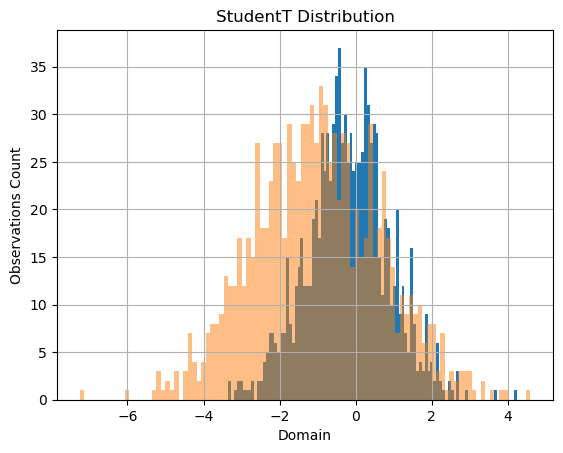

In [44]:
#| hide
loss = StudentTLoss()
adapter = loss.output_distribution.get_adapter(in_features=2)

random_inputs = torch.Tensor(np.random.normal(size=(2, 2)))
distr_args = adapter(random_inputs)
distr = loss.output_distribution.distribution(distr_args)
sample = distr.sample(sample_shape=(1000,))

print('random_inputs.shape', random_inputs.shape)
print('distr_args[0].shape', distr_args[0].shape)
print('sample.shape', sample.shape)
plt.hist(sample[:,0].flatten(), bins=100)
plt.hist(sample[:,1].flatten(), bins=100, alpha=0.5)
plt.xlabel('Domain')
plt.ylabel('Observations Count')
plt.title('StudentT Distribution')
plt.grid()
plt.show()

In [45]:
# distr = StudentT(df=2)
# ver = -distr.log_prob(torch.Tensor([1.,100,-100, -10000000000, 10000000000]))
# ver

## Poisson Mixture Mesh (PMM)

In [46]:
#| export
class PMM(torch.nn.Module):
    """ Poisson Mixture Mesh

    This Poisson Mixture statistical model assumes independence across groups of 
    data $\mathcal{G}=\{[g_{i}]\}$, and estimates relationships within the group.

    $$ \mathrm{P}\\left(\mathbf{y}_{[b][t+1:t+H]}\\right) = 
    \prod_{ [g_{i}] \in \mathcal{G}} \mathrm{P} \\left(\mathbf{y}_{[g_{i}][\\tau]} \\right) =
    \prod_{\\beta\in[g_{i}]} 
    \\left(\sum_{k=1}^{K} w_k \prod_{(\\beta,\\tau) \in [g_i][t+1:t+H]} \mathrm{Poisson}(y_{\\beta,\\tau}, \hat{\\lambda}_{\\beta,\\tau,k}) \\right)$$

    **References:**<br>
    [Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker. 
    Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures. Submitted to the International 
    Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)
    """
    def __init__(self, n_lambdas=10, level=[80, 90], quantiles=None):
        super(PMM, self).__init__()
        # Transform level to MQLoss parameters
        if level:
            qs, self.output_names = level_to_outputs(level)
            quantiles = torch.Tensor(qs)

        # Transform quantiles to homogeneus output names
        if quantiles is not None:
            _, self.output_names = quantiles_to_outputs(quantiles)
            quantiles = torch.Tensor(quantiles)

        self.quantiles = torch.nn.Parameter(quantiles, requires_grad=False)

        self.outputsize_multiplier = n_lambdas
        self.is_distribution_output = True

    def domain_map(self, lambdas_hat: torch.Tensor):
        lambdas_hat = F.softplus(lambdas_hat)
        return (lambdas_hat,)#, weights

    def get_adapter(self, in_features: int) -> torch.nn.Module:
        return Adapter(in_features=in_features, 
                       args_dim={'lambdas': self.outputsize_multiplier},
                       domain_map=self.domain_map)

    def sample(self, distr_args, num_samples=500, loc=None, scale=None):
        lambdas = distr_args[0]
        B, H, K = lambdas.size()
        Q = len(self.quantiles)

        # Sample K ~ Mult(weights)
        # shared across B, H
        # weights = torch.repeat_interleave(input=weights, repeats=H, dim=2)
        weights = (1/K) * torch.ones_like(lambdas).to(lambdas.device)

        # Avoid loop, vectorize
        weights = weights.reshape(-1, K)
        lambdas = lambdas.flatten()        

        # Vectorization trick to recover row_idx
        sample_idxs = torch.multinomial(input=weights, 
                                        num_samples=num_samples,
                                        replacement=True)
        aux_col_idx = torch.unsqueeze(torch.arange(B*H),-1) * K

        # To device
        sample_idxs = sample_idxs.to(lambdas.device)
        aux_col_idx = aux_col_idx.to(lambdas.device)

        sample_idxs = sample_idxs + aux_col_idx
        sample_idxs = sample_idxs.flatten()

        sample_lambdas = lambdas[sample_idxs]

        # Sample y ~ Poisson(lambda) independently
        samples = torch.poisson(sample_lambdas).to(lambdas.device)
        samples = samples.view(B*H, num_samples)

        # Compute quantiles
        quantiles_device = self.quantiles.to(lambdas.device)
        quants = torch.quantile(input=samples, q=quantiles_device, dim=1)
        quants = quants.permute((1,0)) # Q, B*H

        # Final reshapes
        samples = samples.view(B, H, num_samples)
        quants  = quants.view(B, H, Q)

        return samples, quants        
    
    def neglog_likelihood(self,
                          y: torch.Tensor,
                          distr_args: torch.Tensor,
                          mask: Union[torch.Tensor, None] = None,
                          loc: Union[torch.Tensor, None] = None,
                          scale: Union[torch.Tensor, None] = None):
        if mask is None: 
            mask = torch.ones_like(y)

        eps  = 1e-10
        lambdas = distr_args[0]
        B, H, K = lambdas.size()

        lambdas = distr_args[0]
        weights = (1/K) * torch.ones_like(lambdas).to(lambdas.device)

        y = y[:,:,None]
        mask = mask[:,:,None]
        
        log = y * torch.log(lambdas + eps) - lambdas\
              - ( (y) * torch.log(y + eps) - y )   # Stirling's Factorial

        #log  = torch.sum(log, dim=0, keepdim=True) # Joint within batch/group
        #log  = torch.sum(log, dim=1, keepdim=True) # Joint within horizon
        
        # Numerical stability mixture and loglik
        log_max = torch.amax(log, dim=2, keepdim=True) # [1,1,K] (collapsed joints)
        lik     = weights * torch.exp(log-log_max)     # Take max
        loglik  = torch.log(torch.sum(lik, dim=2, keepdim=True)) + log_max # Return max
        loglik  = loglik * mask #replace with mask
        
        loss = -torch.mean(loglik)
        return loss
    
    def __call__(self, y: torch.Tensor,
                 distr_args: Tuple[torch.Tensor],
                 mask: Union[torch.Tensor, None] = None,
                 loc: Union[torch.Tensor, None] = None,
                 scale: Union[torch.Tensor, None] = None):

        return self.neglog_likelihood(y=y, distr_args=distr_args, mask=mask,
                                      loc=loc, scale=scale)


In [47]:
show_doc(PMM, name='PMM.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L867){target="_blank" style="float:right; font-size:smaller"}

### PMM.__init__

>      PMM.__init__ (n_lambdas=10, level=[80, 90], quantiles=None)

Poisson Mixture Mesh

This Poisson Mixture statistical model assumes independence across groups of 
data $\mathcal{G}=\{[g_{i}]\}$, and estimates relationships within the group.

$$ \mathrm{P}\left(\mathbf{y}_{[b][t+1:t+H]}\right) = 
\prod_{ [g_{i}] \in \mathcal{G}} \mathrm{P} \left(\mathbf{y}_{[g_{i}][\tau]} \right) =
\prod_{\beta\in[g_{i}]} 
\left(\sum_{k=1}^{K} w_k \prod_{(\beta,\tau) \in [g_i][t+1:t+H]} \mathrm{Poisson}(y_{\beta,\tau}, \hat{\lambda}_{\beta,\tau,k}) \right)$$

**References:**<br>
[Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker. 
Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures. Submitted to the International 
Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)

In [48]:
show_doc(PMM.sample, name='PMM.sample', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L910){target="_blank" style="float:right; font-size:smaller"}

### PMM.sample

>      PMM.sample (distr_args, num_samples=500, loc=None, scale=None)

In [49]:
show_doc(PMM.__call__, name='PMM.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L982){target="_blank" style="float:right; font-size:smaller"}

### PMM.__call__

>      PMM.__call__ (y:torch.Tensor, distr_args:Tuple[torch.Tensor],
>                    mask:Optional[torch.Tensor]=None,
>                    loc:Optional[torch.Tensor]=None,
>                    scale:Optional[torch.Tensor]=None)

Call self as a function.

In [50]:
#| hide
# Create single mixture and broadcast to N,H,K
weights = torch.ones((1,3))[None, :, :]
lambdas = torch.Tensor([[5,10,15], [10,20,30]])[None, :, :]

# # Create repetitions for the batch dimension N.
N=2
weights = torch.repeat_interleave(input=weights, repeats=N, dim=0)
lambdas = torch.repeat_interleave(input=lambdas, repeats=N, dim=0)

print('weights.shape (N,H,K) \t', weights.shape)
print('lambdas.shape (N,H,K) \t', lambdas.shape)

weights.shape (N,H,K) 	 torch.Size([2, 1, 3])
lambdas.shape (N,H,K) 	 torch.Size([2, 2, 3])


samples.shape (N,H,num_samples)  torch.Size([2, 2, 500])
quants.shape  (N,H,Q) 		 torch.Size([2, 2, 5])


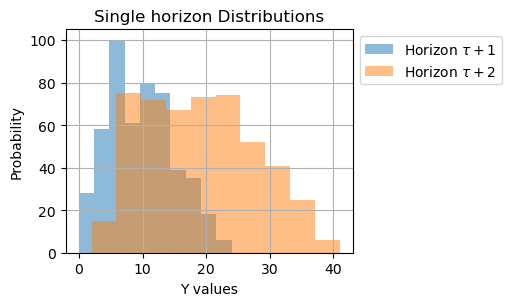

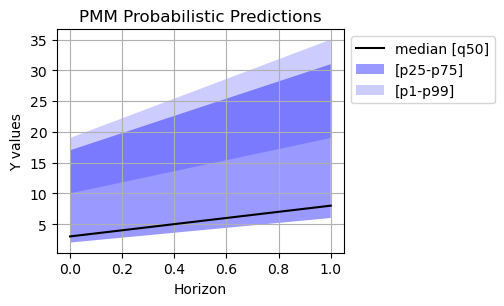

In [51]:
#| hide
model = PMM(quantiles=[0.1, 0.40, 0.5, 0.60, 0.9])
distr_args = (lambdas,)
samples, quants = model.sample(distr_args, num_samples=500)

print('samples.shape (N,H,num_samples) ', samples.shape)
print('quants.shape  (N,H,Q) \t\t', quants.shape)

# Plot synthethic data
x_plot = range(quants.shape[1]) # H length
y_plot_hat = quants[0,:,:]  # Filter N,G,T -> H,Q
samples_hat = samples[0,:,:]  # Filter N,G,T -> H,num_samples

# Kernel density plot for single forecast horizon \tau = t+1
fig, ax = plt.subplots(figsize=(3.7, 2.9))

ax.hist(samples_hat[0,:], alpha=0.5, label=r'Horizon $\tau+1$')
ax.hist(samples_hat[1,:], alpha=0.5, label=r'Horizon $\tau+2$')
ax.set(xlabel='Y values', ylabel='Probability')
plt.title('Single horizon Distributions')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.grid()
plt.show()
plt.close()

# Plot simulated trajectory
fig, ax = plt.subplots(figsize=(3.7, 2.9))
plt.plot(x_plot, y_plot_hat[:,2], color='black', label='median [q50]')
plt.fill_between(x_plot,
                 y1=y_plot_hat[:,1], y2=y_plot_hat[:,3],
                 facecolor='blue', alpha=0.4, label='[p25-p75]')
plt.fill_between(x_plot,
                 y1=y_plot_hat[:,0], y2=y_plot_hat[:,4],
                 facecolor='blue', alpha=0.2, label='[p1-p99]')
ax.set(xlabel='Horizon', ylabel='Y values')
plt.title('PMM Probabilistic Predictions')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.grid()
plt.show()
plt.close()

## Gaussian Mixture Mesh (GMM)

In [52]:
#| export
class GMM(torch.nn.Module):
    """ Gaussian Mixture Mesh

    This Gaussian Mixture statistical model assumes independence across groups of 
    data $\mathcal{G}=\{[g_{i}]\}$, and estimates relationships within the group.

    $$ \mathrm{P}\\left(\mathbf{y}_{[b][t+1:t+H]}\\right) = 
    \prod_{ [g_{i}] \in \mathcal{G}} \mathrm{P}\left(\mathbf{y}_{[g_{i}][\\tau]}\\right)=
    \prod_{\\beta\in[g_{i}]}
    \\left(\sum_{k=1}^{K} w_k \prod_{(\\beta,\\tau) \in [g_i][t+1:t+H]} 
    \mathrm{Gaussian}(y_{\\beta,\\tau}, \hat{\mu}_{\\beta,\\tau,k}, \sigma_{\\beta,\\tau,k})\\right)$$

    **References:**<br>
    [Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker. 
    Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures. Submitted to the International 
    Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)
    """
    def __init__(self, level=[80, 90], quantiles=None):
        super(GMM, self).__init__()
        # Transform level to MQLoss parameters
        if level:
            qs, self.output_names = level_to_outputs(level)
            quantiles = torch.Tensor(qs)

        # Transform quantiles to homogeneus output names
        if quantiles is not None:
            _, self.output_names = quantiles_to_outputs(quantiles)
            quantiles = torch.Tensor(quantiles)

        self.quantiles = torch.nn.Parameter(quantiles, requires_grad=False)
        self.outputsize_multiplier = len(self.output_names)
        self.is_distribution_output = True

    def sample(self, weights, means, stds, num_samples=500):
        B, H, K = means.size()
        Q = len(self.quantiles)
        assert means.shape == stds.shape

        # Sample K ~ Mult(weights)
        # shared across B, H
        # weights = torch.repeat_interleave(input=weights, repeats=H, dim=2)

        # Avoid loop, vectorize
        weights = weights.reshape(-1, K)
        means = means.flatten()
        stds = stds.flatten()

        # Vectorization trick to recover row_idx
        sample_idxs = torch.multinomial(input=weights, 
                                        num_samples=num_samples,
                                        replacement=True)
        aux_col_idx = torch.unsqueeze(torch.arange(B*H),-1) * K

        # To device
        sample_idxs = sample_idxs.to(means.device)
        aux_col_idx = aux_col_idx.to(means.device)

        sample_idxs = sample_idxs + aux_col_idx
        sample_idxs = sample_idxs.flatten()

        sample_means = means[sample_idxs]
        sample_stds  = stds[sample_idxs]

        # Sample y ~ Normal(mu, std) independently
        samples = torch.normal(sample_means, sample_stds).to(means.device)
        samples = samples.view(B*H, num_samples)

        # Compute quantiles
        quantiles_device = self.quantiles.to(means.device)
        quants = torch.quantile(input=samples, q=quantiles_device, dim=1)
        quants = quants.permute((1,0)) # Q, B*H

        # Final reshapes
        samples = samples.view(B, H, num_samples)
        quants  = quants.view(B, H, Q)

        return samples, quants        
    
    def neglog_likelihood(self,
                          y: torch.Tensor,
                          weights: torch.Tensor,
                          means: torch.Tensor,
                          stds: torch.Tensor,
                          mask: Union[torch.Tensor, None] = None):

        if mask is None: 
            mask = torch.ones_like(means)

        B, H, K = means.size()
        # eps  = 1e-10
        
        log  = -0.5 * ((1/stds)*(y - means))**2\
                - torch.log(((2*math.pi)**(0.5)) * stds)

        #log  = torch.sum(log, dim=0, keepdim=True) # Joint within batch/group
        #log  = torch.sum(log, dim=1, keepdim=True) # Joint within horizon

        # Numerical stability mixture and loglik
        log_max = torch.amax(log, dim=2, keepdim=True) # [1,1,K] (collapsed joints)
        lik     = weights * torch.exp(log-log_max)     # Take max
        loglik  = torch.log(torch.sum(lik, dim=2, keepdim=True)) + log_max # Return max
        
        loglik  = loglik * mask #replace with mask

        loss = -torch.mean(loglik)
        return loss
    
    def __call__(self, y: torch.Tensor,
                 weights: torch.Tensor,
                 means: torch.Tensor,
                 stds: torch.Tensor,
                 mask: Union[torch.Tensor, None] = None):

        return self.neglog_likelihood(y=y, weights=weights,
                                 means=means, stds=stds, mask=mask)

In [53]:
show_doc(GMM, name='GMM.__init__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L993){target="_blank" style="float:right; font-size:smaller"}

### GMM.__init__

>      GMM.__init__ (level=[80, 90], quantiles=None)

Gaussian Mixture Mesh

This Gaussian Mixture statistical model assumes independence across groups of 
data $\mathcal{G}=\{[g_{i}]\}$, and estimates relationships within the group.

$$ \mathrm{P}\left(\mathbf{y}_{[b][t+1:t+H]}\right) = 
\prod_{ [g_{i}] \in \mathcal{G}} \mathrm{P}\left(\mathbf{y}_{[g_{i}][\tau]}\right)=
\prod_{\beta\in[g_{i}]}
\left(\sum_{k=1}^{K} w_k \prod_{(\beta,\tau) \in [g_i][t+1:t+H]} 
\mathrm{Gaussian}(y_{\beta,\tau}, \hat{\mu}_{\beta,\tau,k}, \sigma_{\beta,\tau,k})\right)$$

**References:**<br>
[Kin G. Olivares, O. Nganba Meetei, Ruijun Ma, Rohan Reddy, Mengfei Cao, Lee Dicker. 
Probabilistic Hierarchical Forecasting with Deep Poisson Mixtures. Submitted to the International 
Journal Forecasting, Working paper available at arxiv.](https://arxiv.org/pdf/2110.13179.pdf)

In [54]:
show_doc(GMM.sample, name='GMM.sample', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L1026){target="_blank" style="float:right; font-size:smaller"}

### GMM.sample

>      GMM.sample (weights, means, stds, num_samples=500)

In [55]:
show_doc(GMM.__call__, name='GMM.__call__', title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/losses/pytorch.py#L1100){target="_blank" style="float:right; font-size:smaller"}

### GMM.__call__

>      GMM.__call__ (y:torch.Tensor, weights:torch.Tensor, means:torch.Tensor,
>                    stds:torch.Tensor, mask:Optional[torch.Tensor]=None)

Call self as a function.

In [56]:
#| hide
# Create single mixture and broadcast to N,H,K
means   = torch.Tensor([[5,10,15], [10,20,30]])[None, :, :]

# # Create repetitions for the batch dimension N.
N=2
means = torch.repeat_interleave(input=means, repeats=N, dim=0)
weights = torch.ones_like(means)
stds  = torch.ones_like(means)

print('weights.shape (N,H,K) \t', weights.shape)
print('means.shape (N,H,K) \t', means.shape)
print('stds.shape (N,H,K) \t', stds.shape)

weights.shape (N,H,K) 	 torch.Size([2, 2, 3])
means.shape (N,H,K) 	 torch.Size([2, 2, 3])
stds.shape (N,H,K) 	 torch.Size([2, 2, 3])


samples.shape (N,H,num_samples)  torch.Size([2, 2, 2000])
quants.shape  (N,H,Q) 		 torch.Size([2, 2, 5])


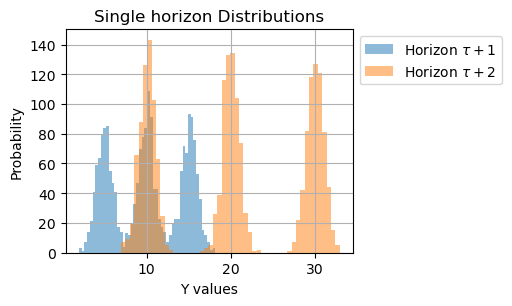

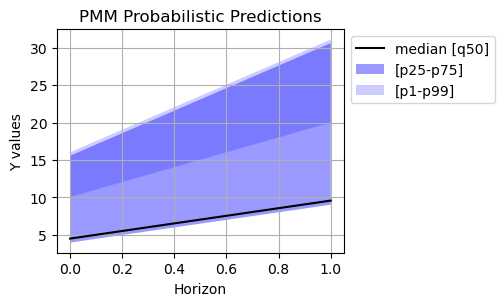

In [57]:
#| hide
model = GMM(quantiles=[0.1, 0.40, 0.5, 0.60, 0.9])
distr_args = (lambdas, weights, stds)
samples, quants = model.sample(weights=weights,
                               means=means, stds=stds,
                               num_samples=2000)

print('samples.shape (N,H,num_samples) ', samples.shape)
print('quants.shape  (N,H,Q) \t\t', quants.shape)

# Plot synthethic data
x_plot = range(quants.shape[1]) # H length
y_plot_hat = quants[0,:,:]  # Filter N,G,T -> H,Q
samples_hat = samples[0,:,:]  # Filter N,G,T -> H,num_samples

# Kernel density plot for single forecast horizon \tau = t+1
fig, ax = plt.subplots(figsize=(3.7, 2.9))

ax.hist(samples_hat[0,:], alpha=0.5, bins=50,
        label=r'Horizon $\tau+1$')
ax.hist(samples_hat[1,:], alpha=0.5, bins=50,
        label=r'Horizon $\tau+2$')
ax.set(xlabel='Y values', ylabel='Probability')
plt.title('Single horizon Distributions')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.grid()
plt.show()
plt.close()

# Plot simulated trajectory
fig, ax = plt.subplots(figsize=(3.7, 2.9))
plt.plot(x_plot, y_plot_hat[:,2], color='black', label='median [q50]')
plt.fill_between(x_plot,
                 y1=y_plot_hat[:,1], y2=y_plot_hat[:,3],
                 facecolor='blue', alpha=0.4, label='[p25-p75]')
plt.fill_between(x_plot,
                 y1=y_plot_hat[:,0], y2=y_plot_hat[:,4],
                 facecolor='blue', alpha=0.2, label='[p1-p99]')
ax.set(xlabel='Horizon', ylabel='Y values')
plt.title('PMM Probabilistic Predictions')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.grid()
plt.show()
plt.close()